<a href="https://colab.research.google.com/github/JordanHT-OIT/electrodynamics/blob/master/midterm_project/PHY330_Midterm_Project_JHT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

{WIP} Put intoduction and context here

\begin{equation}
\Phi_{(\rho,\phi)} \approx V + a_1\rho^{\frac{\pi}{\beta}}\sin{\frac{\pi\phi}{\beta}}
\end{equation}

\begin{equation}
a_1 = \frac{-4V}{\beta d^{\frac{\pi}{\beta}}}
\end{equation}

\begin{equation}
\|E\|_{(\rho,\phi)} \approx \sqrt{(\frac{4V}{\beta d^{\frac{\pi}{\beta}}}\rho^{\frac{\pi}{\beta}-1}\sin{\frac{\pi\phi}{\beta}})^2+(\frac{4V}{\beta d^{\frac{\pi}{\beta}}}\rho^{\frac{\pi}{\beta}}\cos{\frac{\pi\phi}{\beta}})^2}
\end{equation}

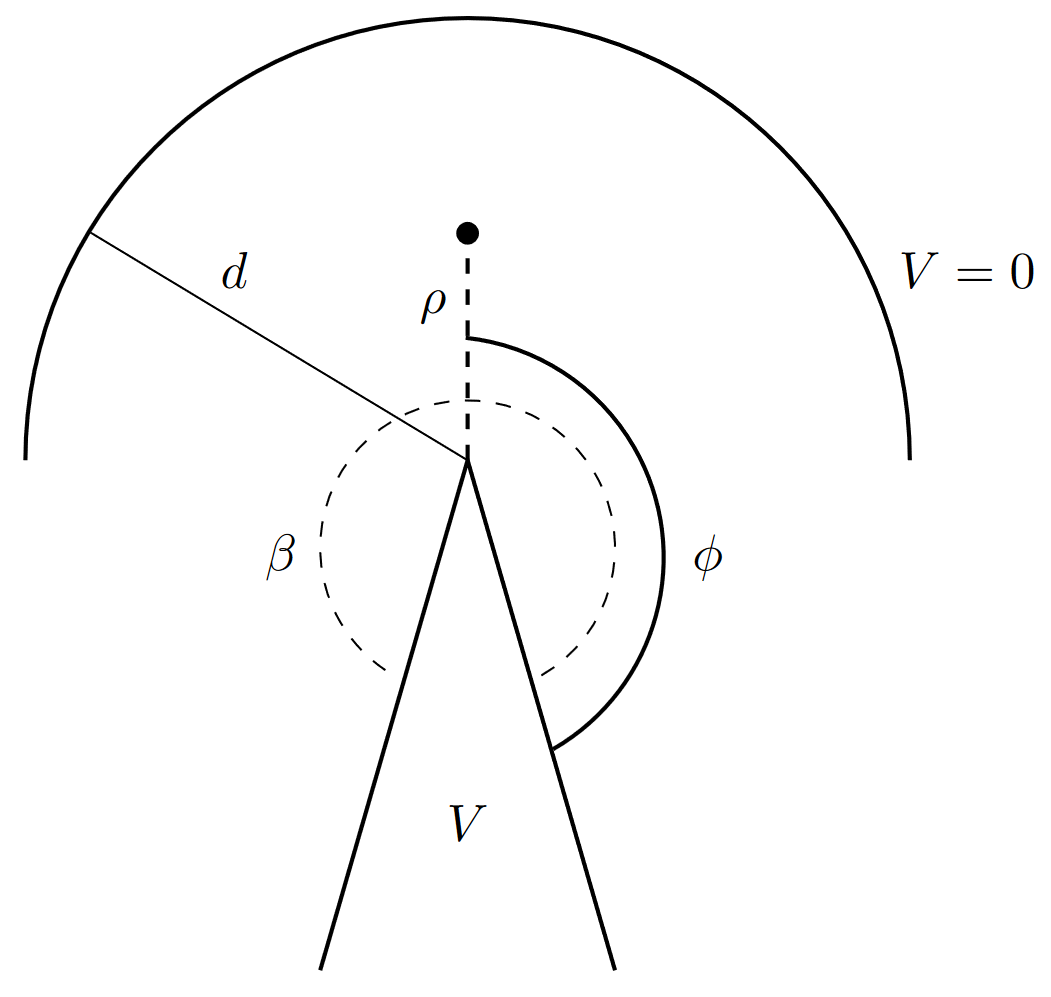

In [ ]:
##Import required libraries (code by Jesse Kinder and FEM on Colab project):

try:
    # Import gmsh library for generating meshes.
    import gmsh
except ImportError:
    # If it is not available, install it.  Then import it.
    !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
    import gmsh

try:
    # Import FEniCSx libraries for finite element analysis.
    import dolfinx
except ImportError:
    # If they are not found, install them.  Then import them.
    !wget "https://fem-on-colab.github.io/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx

try:
    # Import multiphenicsx, mainly for plotting.
    import multiphenicsx
except ImportError:
    # If they are not found, install them.
    !pip3 install "multiphenicsx@git+https://github.com/multiphenics/multiphenicsx.git@8b97b4e"
    import multiphenicsx

# Import the rest of what we need.
import dolfinx.fem
import dolfinx.io
import gmsh
import mpi4py.MPI
import numpy as np
import petsc4py.PETSc
import ufl
import multiphenicsx.fem
import multiphenicsx.io

--2022-11-06 10:25:35--  https://fem-on-colab.github.io/releases/gmsh-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3405 (3.3K) [application/x-sh]
Saving to: ‘/tmp/gmsh-install.sh’

/tmp/gmsh-install.s 100%[===================>]   3.33K  --.-KB/s    in 0s      

2022-11-06 10:25:35 (32.0 MB/s) - ‘/tmp/gmsh-install.sh’ saved [3405/3405]

+ INSTALL_PREFIX=/usr/local
++ awk -F/ '{print NF-1}'
++ echo /usr/local
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ GMSH_INSTALLED=/usr/local/share/fem-on-colab/gmsh.installed
+ [[ ! -f /usr/local/share/fem-on-colab/gmsh.installed ]]
+ H5PY_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/3393a25/releases/h5py-install.sh
+ [[ https://githu

In [ ]:
##Code by Jordan Harris-Toovy, OIT Fall term, 2022

##Setup parametric variables and geometry:

#Radius of the semi-circular "tip" of the cathode
rad_circ = 1

#Distance from the base of the semicircle to the anode
dist_base = 5

#Distance from the center of the base of the semicircle to the side boundaries
dist_side = 5

#Distance from the base of the semicircle to lower boundary
dist_low = 5

#Angle between the vertical and walls of the main cathode
ang_wedge = (3.141592653589793/180) * 30

#Annode-cathode potential difference
pot_diff = 1000

#Conductor permittivity
permi_cond = 1

#Background permittivity
permi_back = 1

#Grid spacing
grid_space = 0.1

#Number of dimensions
DIMS = 2

In [ ]:
##Create gmsh system:

gmsh.initialize()
gmsh.model.add("mesh")

##Define geometry:

#Cathode tip semicircle points & curve (center of model)
pt_ori = gmsh.model.geo.addPoint(0, 0, 0, grid_space)
pt_arc0 = gmsh.model.geo.addPoint(-rad_circ, 0,0, grid_space)
pt_arc1 = gmsh.model.geo.addPoint(0, rad_circ, 0, grid_space)
pt_arc2 = gmsh.model.geo.addPoint(rad_circ, 0, 0, grid_space)

#Due to open arc not being able to have pi or greater angles in gmsh, the semicircle is made of two pi/2 arcs
cont_arc0 = gmsh.model.geo.addCircleArc(pt_arc0, pt_ori, pt_arc1)
cont_arc1 = gmsh.model.geo.addCircleArc(pt_arc1, pt_ori, pt_arc2)

#Top boundary (anode) points & line
pt_top0 = gmsh.model.geo.addPoint(-dist_side, dist_base, 0, grid_space)
pt_top1 = gmsh.model.geo.addPoint(dist_side, dist_base, 0, grid_space)
cont_top = gmsh.model.geo.addLine(pt_top0, pt_top1)

#Side boundarie's points & lines
pt_side0 = gmsh.model.geo.addPoint(-dist_side, -dist_low, 0, grid_space)
pt_side1 = gmsh.model.geo.addPoint(dist_side, -dist_low, 0, grid_space)
cont_side0 = gmsh.model.geo.addLine(pt_top0, pt_side0)
cont_side1 = gmsh.model.geo.addLine(pt_top1, pt_side1)

#Main cathode body points & lines
pt_bot0 = gmsh.model.geo.addPoint((-1.0 * dist_low * np.tan(ang_wedge)), -dist_low, 0, grid_space)
pt_bot1 = gmsh.model.geo.addPoint((dist_low * np.tan(ang_wedge)), -dist_low, 0, grid_space)
cont_cath0 = gmsh.model.geo.addLine(pt_arc0, pt_bot0)
cont_cath1 = gmsh.model.geo.addLine(pt_arc2, pt_bot1)
cont_cath2 = gmsh.model.geo.addLine(pt_bot0, pt_bot1)

#Remaining bottom segments
cont_bot0 = gmsh.model.geo.addLine(pt_side0, pt_bot0)
cont_bot1 = gmsh.model.geo.addLine(pt_side1, pt_bot1)

#Apply new geometry
gmsh.model.geo.synchronize()

In [ ]:
##Setup groups and assign properties

#Cathode as physical group 1
gmsh.model.addPhysicalGroup(DIMS, [cont_arc0, cont_arc1, cont_cath1, cont_cath2, cont_cath0], 1)

#Anode as physical group 2
gmsh.model.addPhysicalGroup(1, [cont_top], 2)

#Sidewalls as physical groups 3 and 4
gmsh.model.addPhysicalGroup(DIMS, [cont_side0, cont_bot0], 3)
gmsh.model.addPhysicalGroup(DIMS, [cont_side1, cont_bot1], 4)

##Create mesh
gmsh.model.mesh.generate(DIMS)

#Export mesh for external viewing
gmsh.write("system_mesh.msh")

##Create FEniCSx objects from gmsh model
FE_mesh, FE_subdoms, FE_bounds = dolfinx.io.gmshio.model_to_mesh(gmsh.model, comm=mpi4py.MPI.COMM_WORLD, rank=0, gdim=DIMS)

#Finalize and exit gmsh system
gmsh.finalize()

In [ ]:
##Rename FEniCSx object groups
FE_cathode = FE_bounds.indices[FE_bounds.values == 1]
FE_anode = FE_bounds.indices[FE_bounds.values == 2]
FE_wall0 = FE_bounds.indices[FE_bounds.values == 3]
FE_wall1 = FE_bounds.indices[FE_bounds.values == 4]

##Plot the resultant geometric objects

#Whole mesh
multiphenicsx.io.plot_mesh(FE_mesh)

#Subdomains
#multiphenicsx.io.plot_mesh_tags(FE_subdoms)

#Boundaries
#multiphenicsx.io.plot_mesh_tags(FE_bounds)